<a href="https://colab.research.google.com/github/ctkerns/cap4630_spring2020/blob/master/hw4_3a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning VGG16 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [15]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-20 12:14:37--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   342MB/s    in 0.2s    

2020-04-20 12:14:37 (342 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with VGG16 convolution base and custom densely connected layers

### Load the convolutional base
*Switched VGG16 with Xception - Christopher Kerns*

In [0]:
from keras.applications import Xception

conv_base = Xception(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers
*This is the part I need to change.*  
*I am going to decrease the size of the relu layer to 100 and see what happens. If training is not succesful and does not create an accurate model, that tells me I may need to increase this number again while being mindful of overfitting.*  
*This is a simple classification problem so I don't think any layers need to be added*
*Activation functions should not change and the final layer should not be changed.*
*-Christopher Kerns*

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5120100   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 25,981,681
Trainable params: 5,120,201
Non-trainable params: 20,861,480
_________________________________________________________________


## Train the model end to end with frozen convolutional base

In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 20s 201ms/step - loss: 0.4782 - acc: 0.7540 - val_loss: 0.0467 - val_acc: 0.9450
Epoch 2/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3794 - acc: 0.8160 - val_loss: 0.2220 - val_acc: 0.9650
Epoch 3/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3528 - acc: 0.8285 - val_loss: 0.1850 - val_acc: 0.9590
Epoch 4/30
100/100 [==============================] - 17s 170ms/step - loss: 0.3431 - acc: 0.8370 - val_loss: 0.0060 - val_acc: 0.9660
Epoch 5/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3113 - acc: 0.8615 - val_loss: 0.0033 - val_acc: 0.9530
Epoch 6/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3528 - acc: 0.8435 - val_loss: 0.0063 - val_acc: 0.9650
Epoch 7/30
100/100 [==============================] - 17s 169ms/step - loss: 0.3313 - acc: 0.8505 - val_lo

## Display curves of loss and accuracy during training

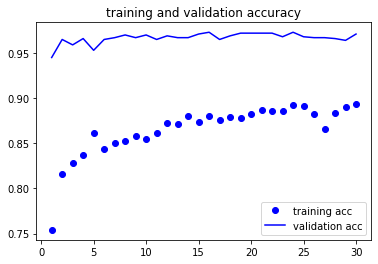

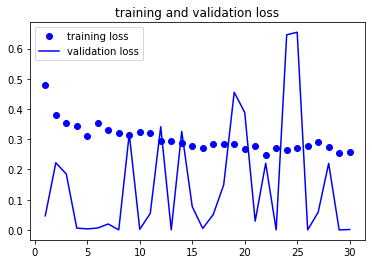

In [23]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning
*I will be unfreezing the last block in the Xception model to allow for some flexibility in the model*  
*I also want to validate that I am doing this correctly so I will print out whether each of the layers are frozen - Christopher Kerns*

In [32]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block14_sepconv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f24a8275588> False
<keras.layers.convolutional.Conv2D object at 0x7f24a82757b8> False
<keras.layers.normalization.BatchNormalization object at 0x7f24a8275be0> False
<keras.layers.core.Activation object at 0x7f24a82759e8> False
<keras.layers.convolutional.Conv2D object at 0x7f2499bbf320> False
<keras.layers.normalization.BatchNormalization object at 0x7f2498d826a0> False
<keras.layers.core.Activation object at 0x7f24a8a509b0> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f24a8ad4dd8> False
<keras.layers.normalization.BatchNormalization object at 0x7f24a8b5acf8> False
<keras.layers.core.Activation object at 0x7f24a8b635c0> False
<keras.layers.convolutional.SeparableConv2D object at 0x7f24a8b7bdd8> False
<keras.layers.normalization.BatchNormalization object at 0x7f24a8b10c50> False
<keras.layers.convolutional.Conv2D object at 0x7f24a8a68f98> False
<keras.layers.pooling.MaxPooling2D object at 0x7f24a8b37e80> False
<keras.la

In [33]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 21s 212ms/step - loss: 0.0933 - acc: 0.9615 - val_loss: 0.2454 - val_acc: 0.9300
Epoch 2/100
100/100 [==============================] - 18s 181ms/step - loss: 0.0761 - acc: 0.9710 - val_loss: 0.0842 - val_acc: 0.9430
Epoch 3/100
100/100 [==============================] - 18s 179ms/step - loss: 0.0703 - acc: 0.9750 - val_loss: 0.0499 - val_acc: 0.9310
Epoch 4/100
100/100 [==============================] - 18s 177ms/step - loss: 0.0936 - acc: 0.9655 - val_loss: 0.0780 - val_acc: 0.9400
Epoch 5/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0959 - acc: 0.9690 - val_loss: 0.0277 - val_acc: 0.9400
Epoch 6/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0907 - acc: 0.9650 - val_loss: 0.0704 - val_acc: 0.9300
Epoch 7/100
100/100 [==============================] - 18s 180ms/step - loss: 0.0987 - acc: 0.9640 - val_loss: 0.1407 - val_acc: 0.9460
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

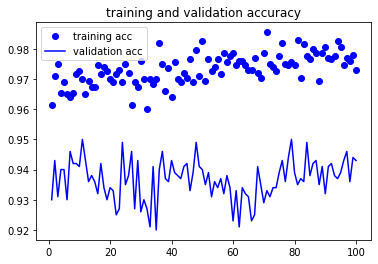

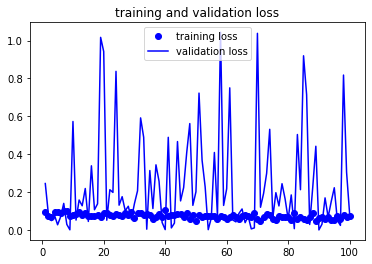

In [34]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.  
*There seems to be less overfitting in my case, but its still there. The model is also not improving very quickly. I need to find a way to increase the ability of the model to learn without adding to the overfitting problem. - Christopher Kerns*

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [36]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.08269871026277542
Validation accuracy: 0.9430000185966492


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)